In [17]:
import numpy as np

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$





# Landau Damping

In [53]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [81]:
%%cython
import cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t      # shorthand type. easy to change
cdef double bspline(int p, int j, double x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        cdef double w
        cdef double w1
        assert ((x >= 0.0) & (x <= 1.0))
        assert ((type(p) == int) & (type(j) == int))
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline(p - 1, j, x) + (1 - w1) * bspline(p - 1, j + 1, x)

class BSpline:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline(p, -(p + 1) // 2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline(p, j - (p + 1) // 2, 0.0) * 2 * np.cos(j * self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    def interpolate_disp(self, np.ndarray[dtype_t, ndim=1] f, double alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        cdef int p
        cdef int ishift
        cdef double beta
        cdef Py_ssize_t j
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p - 1) // 2, (p + 1) // 2 + 1):
            self.eigalpha += bspline(p, j - (p + 1) // 2, beta) * np.exp((ishift + j) * 1j * self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(np.fft.ifft(np.fft.fft(f) * self.eigalpha / self.eig_bspl))


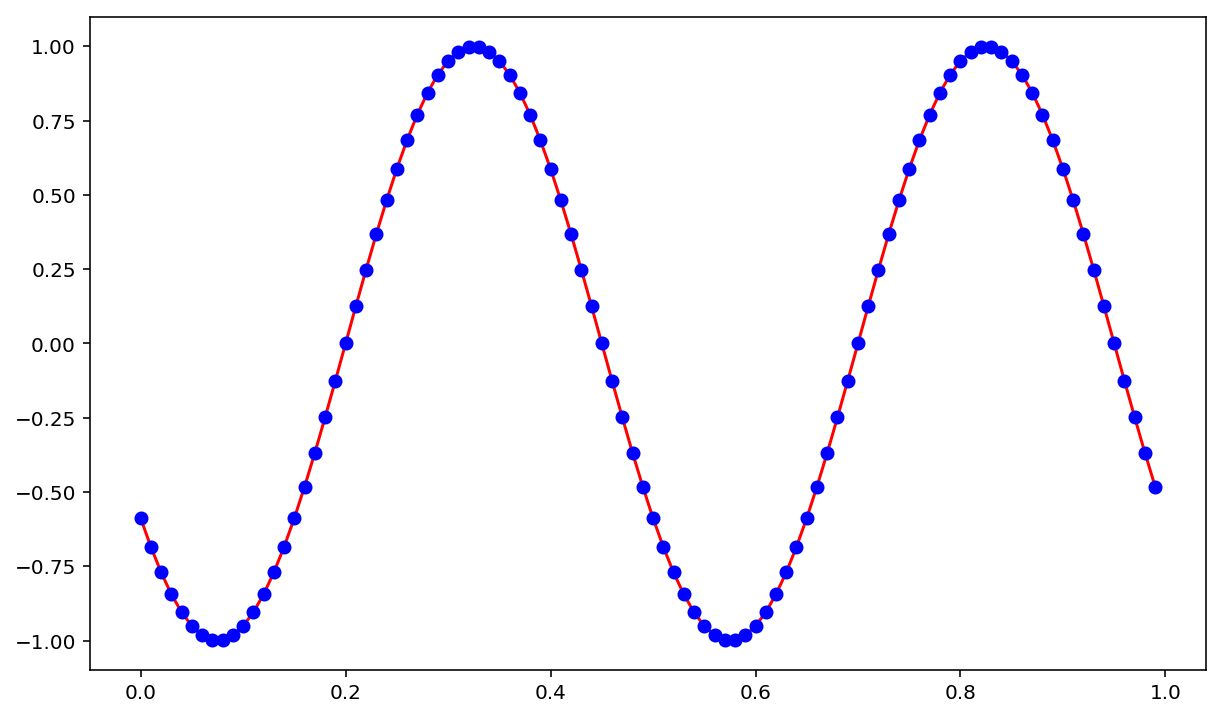

In [82]:
n =100
cs = BSpline(3,0,1,n)
x = np.linspace(0,1,n, endpoint=False)
f = np.sin(x*4*np.pi)
alpha = 0.2
plt.plot( x, np.sin((x-alpha)*4*np.pi), 'r-', x, cs.interpolate_disp(f, alpha),'bo');

In [1]:
class EricVlasovPoisson:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv, f = None):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True )
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)

        if f is not None : 
            self.f = f
        else:
            self.f = np.zeros((nx,nv))
            
        self.cs_x = BSpline(3, xmin, xmax, nx)
        self.cs_v = BSpline(3, vmin, vmax, nv)
        self.modes = 2 * np.pi * (np.arange(nx / 2 + 1)) / (xmax - xmin)
        self.modes[0] = 1.  # avoid division by 0
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax
        
    def advection_x(self, dt):
        for j in range(self.nv):
            alpha = dt * self.v[j]
            self.f[:,j] = self.cs_x.interpolate_disp(self.f[:,j], alpha)
            
    def advection_v(self, e, dt):
        for i in range(self.nx):
            alpha = dt * e[i] 
            self.f[i,:] = self.cs_v.interpolate_disp(self.f[i,:], alpha)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=1)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = np.fft.rfft(rho)
        return np.fft.irfft(-1j*rhok/self.modes)

dt = 0.02004008016032064
0,100,200,300,400,CPU times: user 15.4 s, sys: 355 ms, total: 15.7 s
Wall time: 15.8 s


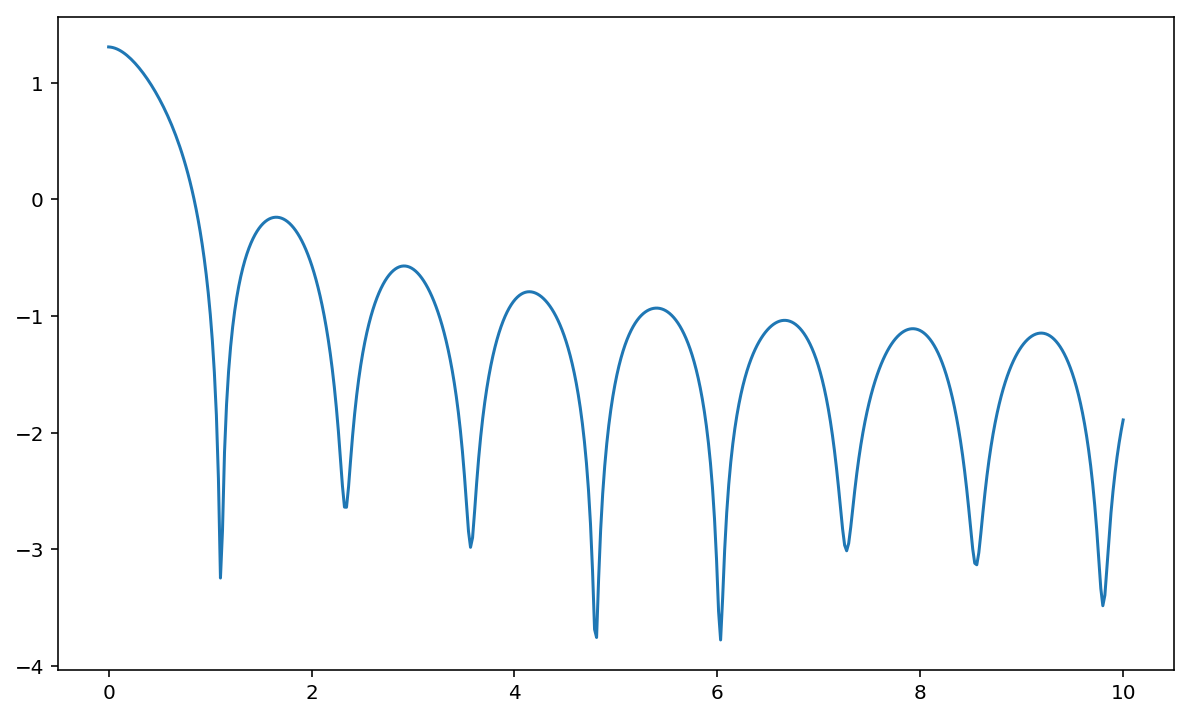

In [106]:
%%time
sim = EricVlasovPoisson(xmin = 0.0, xmax = 4*np.pi, nx = 100,
             vmin = -6., vmax = 6., nv = 100)

X, V = np.meshgrid(sim.x, sim.v)
eps = 0.05
kx  = 0.5 
sim.f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)

nstep = 500

t, dt = np.linspace(0.0, 10.0, nstep, retstep=True)
nrj = []
print("dt = {}".format(dt))

sim.advection_x(0.5*dt)
for istep in range(nstep):
    rho = sim.compute_rho()
    e = sim.compute_e(rho)
    sim.advection_v(e, dt)
    sim.advection_x(dt)
    nrj.append( 0.5*np.log(np.sum(e*e)*sim.dx))
    if (istep % 100 == 0 ): print(istep,end=',')

plt.plot(t, nrj)

# Cubic Spline Interpolator

In [104]:
from math import floor
class Interpolator():
    
    num_terms = 27
    
    def __init__(self, n, xmin, xmax):
        
        assert ( n > self.num_terms)
        self.n      = n
        self.xmin   = xmin
        self.xmax   = xmax
        self.rdelta = (n-1) / (xmax - xmin)
        self.d      = np.zeros(n)
        self.coeffs = np.zeros(n+3)
        self.interp = np.vectorize(self.interpolate)
        
    def compute_interpolants( self, f ):
        
        n = self.n
        num_terms = self.num_terms
        a=np.sqrt((2.0+np.sqrt(3.0))/6.0)
        r_a = 1.0/a
        b=np.sqrt((2.0-np.sqrt(3.0))/6.0)
        b_a = b/a

        d1 = f[0]
        coeff_tmp = 1.0
        for i in range(num_terms):
           coeff_tmp *= (-b_a)
           d1 += coeff_tmp*f[n-2-i]

        self.d[0] = d1*r_a
        for i in range(1,n-1):
            self.d[i] = r_a*(f[i] - b*self.d[i-1])
        
        d1        = self.d[-2]
        coeff_tmp = 1.0
        for i in range(num_terms):
           coeff_tmp *= (-b_a)
           d1 += coeff_tmp*self.d[i]

        self.coeffs[n-1] = d1*r_a
    
        for i in range(n-2, 0, -1):
           self.coeffs[i] = r_a*(self.d[i-1] - b*self.coeffs[i+1])

        self.coeffs[0]  = self.coeffs[-4]
        self.coeffs[-1:-4:-1] = self.coeffs[3:0:-1]
        
    def interpolate( self, x ):
        
        rh      = self.rdelta
        t0      = (x-self.xmin)*rh
        cell    = floor(t0)
        dx      = t0 - cell
        cdx     = 1.0 - dx
        cim1    = self.coeffs[cell]
        ci      = self.coeffs[cell+1]
        cip1    = self.coeffs[cell+2]
        cip2    = self.coeffs[cell+3]
        t1      = 3.0*ci
        t3      = 3.0*cip1
        t2      = cdx*(cdx*(cdx*(cim1 - t1) + t1) + t1) + ci
        t4      =  dx*( dx*( dx*(cip2 - t3) + t3) + t3) + cip1
            
        return (t2 + t4) / 6.0
    


## Interpolation test

In [71]:
n =50
cs = Interpolator(n,0,1)
x = np.linspace(0,1,n)
y = np.sin(x*2*np.pi)
x_new = x.min() + np.random.random(n) * (x.max() - x.min())
x_new.sort()

In [72]:
%%timeit
cs.compute_interpolants(y)
y_new = cs.interp(x_new)

358 µs ± 6.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


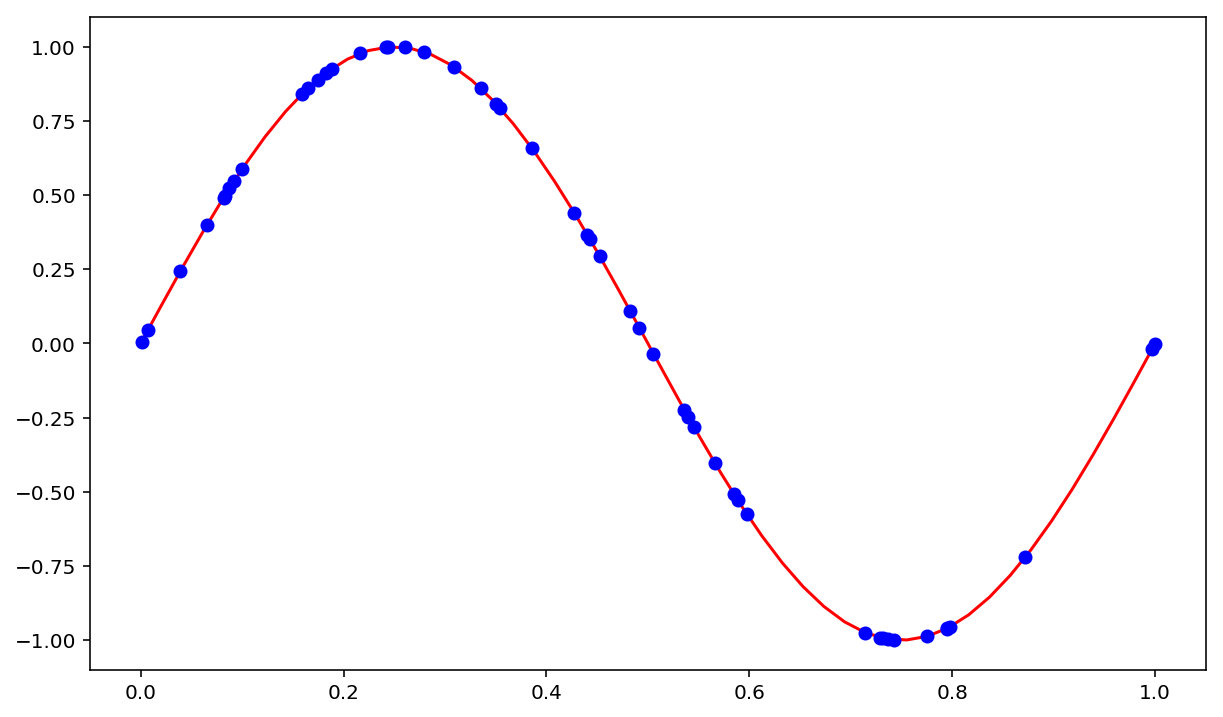

In [73]:
plt.plot(x, y, 'r-', x_new, cs.interp(x_new),'bo');

In [74]:
class VlasovPoisson:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv, f = None):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, retstep=True )
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, retstep=True)

        if f is not None : 
            self.f = f
        else:
            self.f = np.zeros((nx,nv))
            
        self.cs_x = Interpolator(nx, xmin, xmax)
        self.cs_v = Interpolator(nv, vmin, vmax)
        self.modes = 2 * np.pi * (np.arange(nx / 2 + 1)) / (xmax - xmin)
        self.modes[0] = 1.  # avoid division by 0
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax
        
        self.interp_x = np.vectorize(self.cs_x.interpolate)
        self.interp_v = np.vectorize(self.cs_v.interpolate)

    def advection_x(self, dt):
        for j in range(self.nv):
            self.cs_x.compute_interpolants(self.f[:,j])
            x_new = self.x - dt * self.v[j]
            x_new = self.xmin + np.mod( x_new - self.xmin, self.xmax-self.xmin)
            self.f[:,j] = self.interp_x(x_new)

    def advection_v(self, e, dt):
        for i in range(self.nx):
            self.cs_v.compute_interpolants(self.f[i,:])
            v_new = self.v - dt * e[i] 
            v_new = self.vmin + np.mod( v_new - self.vmin, self.vmax-self.vmin)
            self.f[i,:] = self.interp_v(v_new)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=1)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = np.fft.rfft(rho)
        return np.fft.irfft(-1j*rhok/self.modes)

In [75]:

sim = VlasovPoisson(xmin = 0.0, xmax = 4*np.pi, nx = 100,
             vmin = -6., vmax = 6., nv = 100)

X, V = np.meshgrid(sim.x, sim.v)
eps = 0.05
kx  = 0.5 
sim.f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)

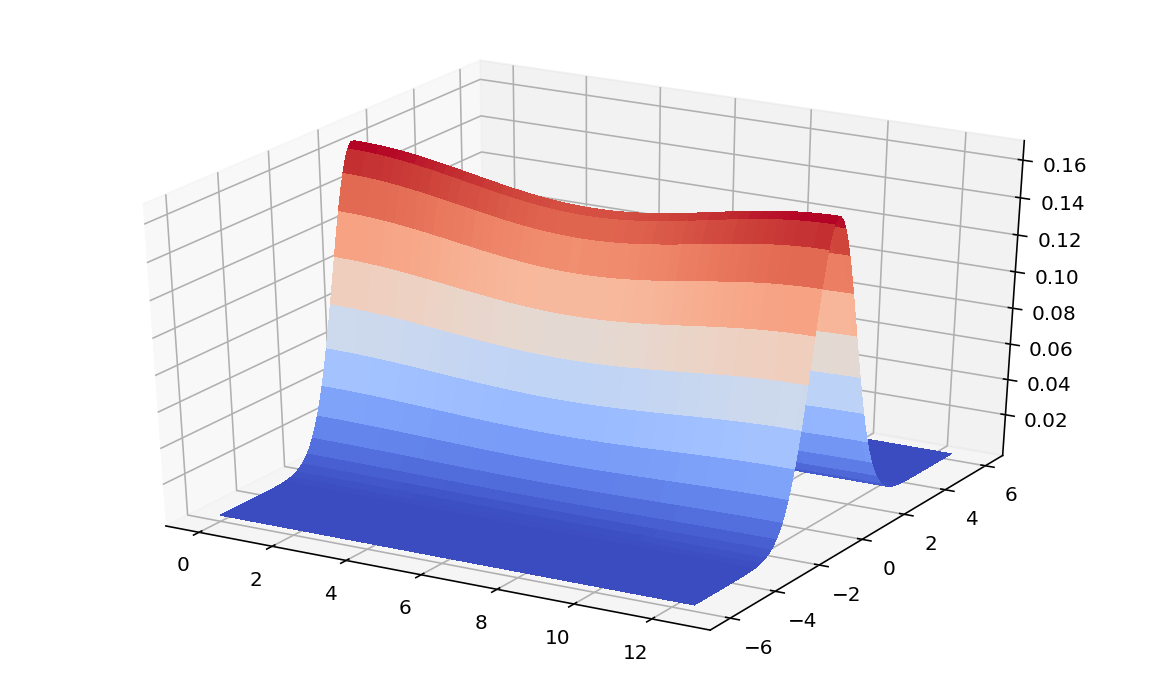

In [76]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = (10.0, 6.0)
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, V, sim.f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


dt = 0.02004008016032064
0,100,200,300,400,CPU times: user 1min 6s, sys: 761 ms, total: 1min 7s
Wall time: 1min 8s


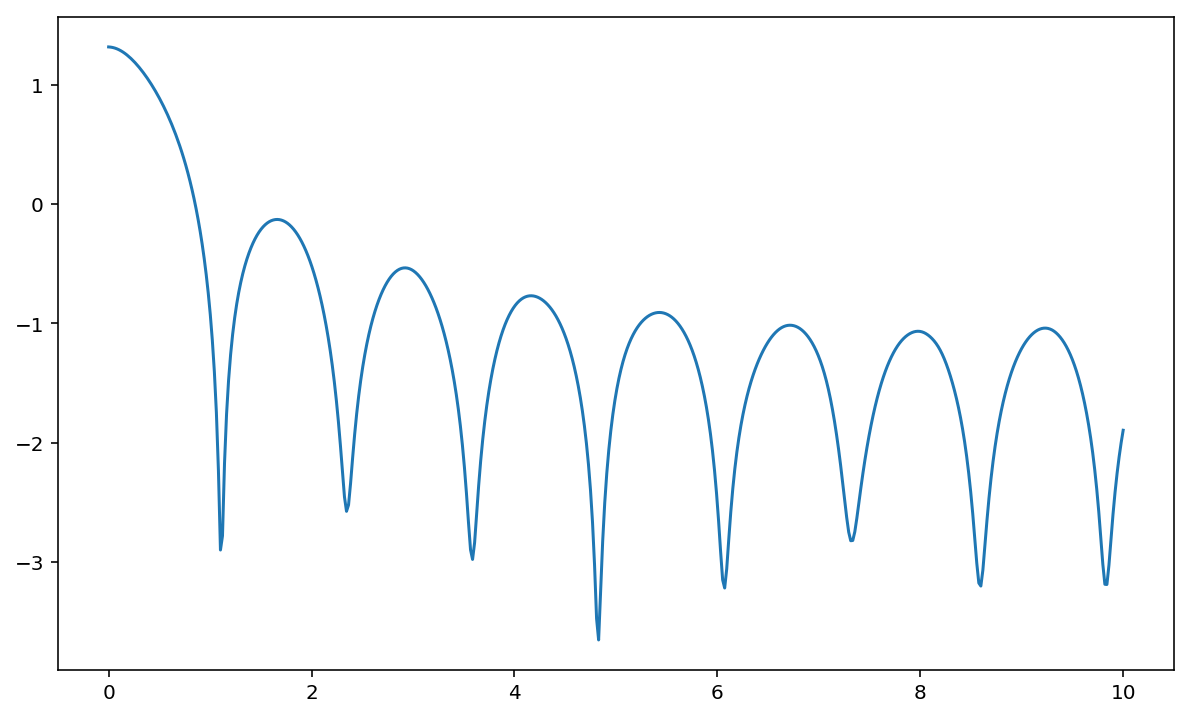

In [77]:
%%time
nstep = 500
t, dt = np.linspace(0.0, 10.0, nstep, retstep=True)
nrj = []
print("dt = {}".format(dt))
sim.advection_x(0.5*dt)
for istep in range(nstep):
    rho = sim.compute_rho()
    e = sim.compute_e(rho)
    sim.advection_v(e, dt)
    sim.advection_x(dt)
    nrj.append( 0.5*np.log(np.sum(e*e)*sim.dx))
    if (istep % 100 == 0 ): print(istep,end=',')

plt.plot(t, nrj)

In [111]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np

n = 4
f = np.arange(n*n).reshape(n,n)
v = np.arange(n)
print(f)
def add( f1d, inc ):
    return f1d + inc

e = ThreadPoolExecutor(4)

tasks = [e.submit(add, f[i,:], v[i]) for i in range(n)]
for i,t in enumerate(tasks):
    f[i,:] = t.result()

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
